# California Trail Quality and Accessibility Analysis

In [1]:
#importing modules
!pip install geopy
!pip install lxml html5lib selenium
!pip install lxml
!pip install openpyxl
!pip install seaborn
!pip install scikit-learn
!pip install geopy
!pip install lxml html5lib selenium
!pip install lxml
!pip install openpyxl
!pip import requests
!pip from bs4 import BeautifulSoup
!pip import pandas as pd
!pip from io import StringIO
!pip import json
!pip from geopy.geocoders import Nominatim
!pip from geopy.distance import geodesic
!pip import time
!pip import re
!pip import matplotlib.pyplot as plt
!pip import seaborn as sns
!pip from sklearn.linear_model import LinearRegression
!pip from sklearn.cluster import KMeans
!pip from sklearn.preprocessing import StandardScaler
!pip from sklearn.model_selection import train_test_split
!pip from sklearn.metrics import r2_score

ERROR: unknown command "import"
ERROR: unknown command "from"
ERROR: unknown command "import"
ERROR: unknown command "from"
ERROR: unknown command "import"
ERROR: unknown command "from"
ERROR: unknown command "from"
ERROR: unknown command "import"
ERROR: unknown command "import"
ERROR: unknown command "import"
ERROR: unknown command "import"
ERROR: unknown command "from"
ERROR: unknown command "from"
ERROR: unknown command "from"
ERROR: unknown command "from"
ERROR: unknown command "from"


# Video Presentation
**IMPORTANT: WHEN I MADE THE VIDEO THE DATA WAS OLDER SO THE GRAPHS WILL LOOK DIFFERENT FROM WHAT IS SHOWN BELOW BECAUSE THE GRAPHS BELOW ARE CREATED WITH THE MOST UP TO DATE INFORMATION.

https://youtu.be/_0zSv90fNO0

# Data Collection and Cleaning

## Downloaded Dataset Requirement



In [23]:
#imported modules to work with the data and manipulate it
import numpy as np
import pandas as pd

def rec_routes(file):
    df = pd.read_csv(file) #reads the CSV file into a pandas DataFrame
    
    #replaces all missing or NaN values in the DataFrame with "Undetermined" (inplace changes the original df)
    df.fillna("Undetermined", inplace=True)
    #looks at "ROUTECAT" column and changes 'rd' to 'Rd'
    df["ROUTECAT"] = np.where(df["ROUTECAT"] == "Primitive rd", "Primitive Rd", df["ROUTECAT"])
    #looks at "ROUTECAT" column and changes all unknown elements to "Undetermined"
    df["ROUTECAT"] = np.where((df["ROUTECAT"] == "Not determined")|(df["ROUTECAT"] == "Undetermined")|(df["ROUTECAT"] == "Unknown"), "Undetermined", df["ROUTECAT"])
    
    #replaces certain phrases to be uniform among all datasets (inplace changes the original df)
    df.replace("Trl", "Trail", inplace=True)
    df.replace("Road w/ Bike Lane", "Road with Bike Lane", inplace=True)
    df.replace("Decommision", "Decommissioned", inplace=True)
    
    #writes the cleaned df to a new CSV file called CleanRecreationalRoutes.csv
    df.to_csv('CleanRecreationalRoutes.csv', index=False)


############ Function Call ############
rec_routes('RecreationalRoutes.csv')

/var/folders/2y/gdy996mn7l7cbqt8v0_0vr640000gn/T/ipykernel_33593/3353562070.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Undetermined' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("Undetermined", inplace=True)


## Web Collection Requirement \#1


In [24]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
from selenium import webdriver
from bs4 import BeautifulSoup
import time

driver = webdriver.Chrome()
driver.get("https://weatherspark.com/countries/US/CA")
time.sleep(5)   # allow JS to run

soup = BeautifulSoup(driver.page_source, "html.parser")


#Find all tables on the page
tables = soup.find_all("table")

clearer_table = None
highs_table = None

#Identify the "Clearer Skies" and "High" tables
for table in tables:
    text = table.get_text()
    if "Clearer Skies" in text:
        clearer_table = table
    elif "High" in text and "Jan" in text:  # catches the high temp table
        highs_table = table

#Convert both HTML tables to pandas DataFrames
def parse_table(table_html):
    df = pd.read_html(StringIO(str(table_html)))[0]
    df.columns = [col.strip() for col in df.columns]
    df = df.replace({'Â': ''}, regex=True)
    return df

clearer_df = parse_table(clearer_table)
highs_df = parse_table(highs_table)

#Clean up the "Clearer Skies" table
clearer_df.rename(columns={clearer_df.columns[0]: "City"}, inplace=True)

#Convert percent to decimal form
for col in clearer_df.columns[1:]:
    clearer_df[col] = clearer_df[col].str.replace('%', '').astype(float) / 100

#Save both to one Excel file
with pd.ExcelWriter("California_Weather.xlsx") as writer:
    clearer_df.to_excel(writer, sheet_name="Clearer Skies", index=False)
    highs_df.to_excel(writer, sheet_name="High Temperatures", index=False)

print("✅ Extraction complete! Saved to California_Weather.xlsx")
print(clearer_df.head())


            City   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct  \
0    Los Angeles  0.61  0.58  0.64  0.73  0.78  0.87  0.89  0.90  0.90  0.80   
1  San Francisco  0.47  0.47  0.51  0.58  0.67  0.81  0.90  0.90  0.87  0.72   
2     Sacramento  0.45  0.45  0.49  0.58  0.68  0.81  0.90  0.90  0.86  0.72   
3   Palm Springs  0.64  0.60  0.67  0.75  0.79  0.87  0.85  0.86  0.89  0.81   
4         Eureka  0.34  0.34  0.36  0.44  0.54  0.70  0.86  0.87  0.80  0.61   

    Nov   Dec  
0  0.70  0.62  
1  0.56  0.49  
2  0.54  0.48  
3  0.71  0.64  
4  0.39  0.34  


## Web Collection Requirement #2

In [25]:
import json
import pandas as pd
#a geocoding tool that converts city names into latitude/longitude coordinates.
from geopy.geocoders import Nominatim
#calculates the distance between two coordinates (in kilometers)
from geopy.distance import geodesic
#used to add time between requests to avoid crashing the system
import time

def yelp(file):
    # opens the Yelp data file in read mode and parses the JSON file into list of dictionaries
    with open(file, 'r') as f:
        data = json.load(f)

    trails = [] #intialize empty list
    #iterates through each record in the loaded JSON
    for record in data:
        businesses = record.get("data", {}).get("businesses", [])
        #goes to the businesses part of the dictionary and safely(does not error if it does not find it) gets the different values
        for b in businesses:
            name = b.get("name", "No Name Found")
            rating = b.get("rating", 0)
            reviews = b.get("reviewCount", 0)
            location = b.get("location", {}).get("address", {})
            city = location.get("city", "Unknown")

            #adds a dictionary for each trail to the trails list
            trails.append({
                "name": name.strip(),
                "city": city.strip(), #if isinstance(city, str) else "Unknown",
                "rating": rating,
                "reviews": reviews
            })

    #converts trails list into a dataframe df (comlumns are name, city, rating, reviews)
    df = pd.DataFrame(trails)

    # Sorts all entries by reviews (most to least). Drops duplicates that share the same "name" (keeps the one with the most reviews)
    #df = df.sort_values("reviews", ascending=False).drop_duplicates(subset=["name"], keep="first")

    # computes Bayesian Rating to calcuate a true rating
    # filters out ratings of 0 and computes the average rating (C)
    # sets a threshold m (25 reviews) that controls how much weight to give to the average vs. individual ratings.
    ratings = df[df["rating"] > 0]["rating"]
    C = ratings.mean() if not ratings.empty else 0
    m = 25  # Minimum review threshold

    #If a trail has many reviews, its own rating dominates.
    #If it has few reviews, the global average (C) influences it more.
    df["true_rating"] = df.apply(
        lambda row: (row["reviews"] / (row["reviews"] + m)) * row["rating"]
        + (m / (row["reviews"] + m)) * C
        if row["rating"] > 0 else 0,
        axis=1
    )

    #removes rows with missing data and rounds
    df = df[df["rating"] > 0]
    df["true_rating"] = df["true_rating"].round(2)
    df["rating"] = df["rating"].round(1)
    df = (
        df.assign(city_priority=df["city"].eq("Unknown"))  # True for Unknown
          .sort_values(["name", "city_priority"])          # Unknown goes last
          .drop_duplicates(subset=["name"], keep="first")  # keep best version
          .drop(columns="city_priority")
    )

    # Defines 5 major California city coordinates to compare distances to.
    base_cities = {
        "Los Angeles": (34.0522, -118.2437),
        "San Francisco": (37.7749, -122.4194),
        "Sacramento": (38.5816, -121.4944),
        "Palm Springs": (33.8303, -116.5453),
        "Eureka": (40.8021, -124.1637)
    }

    # Iterates through each unique city name.
    # Looks up its coordinates (latitude, longitude).
    # Stores results in city_coords.
    # Sleeps 1 second per lookup to avoid overloading the API.

    geolocator = Nominatim(user_agent="trail_locator")
    city_coords = {}

    for city in df["city"].dropna().unique():
        try:
            loc = geolocator.geocode(city + ", California", timeout=5)
            if loc:
                city_coords[city] = (loc.latitude, loc.longitude)
                time.sleep(1)  # pause to not get overloaded
        except Exception as e:
            print(f"Error geocoding {city}: {e}")

    # a function that finds the closes major city
    # Checks if the city has coordinates.
    # Calculates distances (in km) to each major city using geodesic().
    # Returns the closest one.
    def nearest_major_city(city):
        if city not in city_coords:
            return "Unknown"
        city_point = city_coords[city]
        distances = {base: geodesic(city_point, coords).km for base, coords in base_cities.items()}
        return min(distances, key=distances.get)

    df["nearest_major_city"] = df["city"].apply(nearest_major_city)

    # displays a summary of the trails sorted by the true_rating
    print("\nCalifornia Trails: Sorted by True Rating\n")
    print(df[["name", "city", "nearest_major_city", "rating", "reviews", "true_rating"]]
          .sort_values(by="true_rating", ascending=False)
          .to_string(index=False))

    # saved cleaned data to 'trail_ratings_with_cities.csv'
    df.to_csv("trail_ratings_with_cities.csv", index=False)
    
    return df
yelp('calitrailreviews.json')


California Trails: Sorted by True Rating

                               name        city nearest_major_city  rating  reviews  true_rating
                      Rubicon Trail  Sacramento         Sacramento     4.9       58         4.76
Monterey Bay Sanctuary Scenic Trail    Monterey      San Francisco     4.8      110         4.74
                  Castle Rock Trail   Los Gatos      San Francisco     4.6      422         4.59
              Beach Promenade Trail Los Angeles        Los Angeles     4.6      119         4.57
              Donner Creek Overlook     Truckee         Sacramento     4.9        8         4.56
                Sawmill Creek Trail      Hughes        Los Angeles     4.5        2         4.45
              Soberanes Point Trail    Monterey      San Francisco     4.0        1         4.43
                       Summit Trail   San Ramon      San Francisco     4.3       16         4.39
                 Saratoga Gap Trail   Los Gatos      San Francisco     3.8       18 

,name,city,rating,reviews,true_rating,nearest_major_city
19,Beach Promenade Trail,Los Angeles,4.6,119,4.57,Los Angeles
17,Castle Rock Trail,Los Gatos,4.6,422,4.59,San Francisco
12,Donner Creek Overlook,Truckee,4.9,8,4.56,Sacramento
15,Los Vaqueros Trail,Brentwood,3.9,78,4.03,San Francisco
16,Monterey Bay Sanctuary Scenic Trail,Monterey,4.8,110,4.74,San Francisco
13,Rubicon Trail,Sacramento,4.9,58,4.76,Sacramento
18,Saratoga Gap Trail,Los Gatos,3.8,18,4.18,San Francisco
14,Sawmill Creek Trail,Hughes,4.5,2,4.45,Los Angeles
11,Soberanes Point Trail,Monterey,4.0,1,4.43,San Francisco
10,Summit Trail,San Ramon,4.3,16,4.39,San Francisco


## Additional Cleaning Functions

In [26]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import json
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time
import re

def analyze_trails(yelp_file='calitrailreviews.json', routes_file='CleanRecreationalRoutes.csv'):
    # scrape weather website to get the right table
    #url = "https://weatherspark.com/countries/US/CA"
    #response = requests.get(url)
    #response.encoding = 'utf-8'
    #soup = BeautifulSoup(response.text, "html.parser")

    # Find all tables on the page
    #tables = soup.find_all("table")

    # Identify the specific table containing "Clearer Skies" percentages
    #clearer_table = None
    #for table in tables:
        #text = table.get_text()
        # Look for markers that indicate we're looking at the right table
        #if "Clearer" in text and "%" in text:
            #clearer_table = table
            #break

    #if clearer_table is None:
        #raise ValueError("Could not find the 'Clearer Skies' table on WeatherSpark!")

    data = [
        ["Los Angeles",   0.61, 0.58, 0.64, 0.73, 0.78, 0.87, 0.89, 0.90, 0.90, 0.80, 0.70, 0.62],
        ["San Francisco", 0.47, 0.47, 0.51, 0.58, 0.67, 0.81, 0.90, 0.90, 0.87, 0.72, 0.56, 0.49],
        ["Sacramento",    0.45, 0.45, 0.49, 0.58, 0.68, 0.81, 0.90, 0.90, 0.86, 0.72, 0.54, 0.48],
        ["Palm Springs",  0.64, 0.60, 0.67, 0.75, 0.79, 0.87, 0.85, 0.86, 0.89, 0.81, 0.71, 0.64],
        ["Eureka",        0.34, 0.34, 0.36, 0.44, 0.54, 0.70, 0.86, 0.87, 0.80, 0.61, 0.39, 0.34],
    ]

    columns = [
        "City","Jan","Feb","Mar","Apr","May","Jun",
        "Jul","Aug","Sep","Oct","Nov","Dec"
    ]

    clearer_df = pd.DataFrame(data, columns=columns)

    clearer_df.to_excel("California_Weather.xlsx", sheet_name="Clearer Skies", index=False)


    # Convert the HTML table to a DataFrame safely
    #clearer_df = pd.read_html(StringIO(str(clearer_table)))[0]

    # Clean the column names
    #clearer_df.columns = [col[0].strip() if isinstance(col, tuple) else str(col).strip() for col in clearer_df.columns]
    #clearer_df.rename(columns={clearer_df.columns[0]: "City"}, inplace=True)

    # Remove stray characters
    #clearer_df = clearer_df.replace({'Â': '', '°F': ''}, regex=True)

    # Identify columns containing actual percentages
    #percent_cols = [c for c in clearer_df.columns if c != "City"]

    # Convert percentage strings like "75%" to 0.75
    #for col in percent_cols:
        #try:
            #clearer_df[col] = clearer_df[col].astype(str).str.replace('%', '', regex=False)
            #clearer_df[col] = pd.to_numeric(clearer_df[col], errors='coerce') / 100
        #except Exception:
            #clearer_df[col] = None

    # Remove empty rows
    #clearer_df.dropna(how="all", inplace=True)

    # Save weather data
    #clearer_df.to_excel("California_Weather.xlsx", sheet_name="Clearer Skies", index=False)


    # load in yelp data
    with open(yelp_file, 'r') as f:
        data = json.load(f)

    trails = []
    # Extract business-level trail data from Yelp JSON
    for record in data:
        businesses = record.get("data", {}).get("businesses", [])
        for b in businesses:
            name = b.get("name", "No Name Found")
            rating = b.get("rating", 0)
            reviews = b.get("reviewCount", 0)
            location = b.get("location", {}).get("address", {})
            city = location.get("city", "Unknown")

            trails.append({
                "name": name.strip(),
                "city": city.strip(),
                "rating": rating,
                "reviews": reviews
            })

    # Convert to DataFrame
    df = pd.DataFrame(trails)

    # Compute weighted rating using formula
    ratings = df[df["rating"] > 0]["rating"]
    C = ratings.mean() if not ratings.empty else 0  # global average rating
    m = 25  # minimum review threshold

    df["true_rating"] = df.apply(
        lambda row: (row["reviews"] / (row["reviews"] + m)) * row["rating"]
        + (m / (row["reviews"] + m)) * C if row["rating"] > 0 else 0,
        axis=1
    )

    # Clean ratings and remove unrated trails
    df = df[df["rating"] > 0]
    df["true_rating"] = df["true_rating"].round(2)
    df["rating"] = df["rating"].round(1)

    # Deduplicate trails: prefer entries with real cities over "Unknown"
    df = (
        df.assign(city_priority=df["city"].eq("Unknown"))
          .sort_values(["name", "city_priority"])
          .drop_duplicates(subset=["name"], keep="first")
          .drop(columns="city_priority")
    )

    #  Geocode cities to find nearest major california city
    base_cities = {
        "Los Angeles": (34.0522, -118.2437),
        "San Francisco": (37.7749, -122.4194),
        "Sacramento": (38.5816, -121.4944),
        "Palm Springs": (33.8303, -116.5453),
        "Eureka": (40.8021, -124.1637)
    }

    geolocator = Nominatim(user_agent="trail_locator")
    city_coords = {}

    # Geocode each unique city name in the dataset
    for city in df["city"].dropna().unique():
        try:
            loc = geolocator.geocode(city + ", California", timeout=5)
            if loc:
                city_coords[city] = (loc.latitude, loc.longitude)
                time.sleep(1)  # avoid API rate-limiting
        except Exception as e:
            print(f"Error geocoding {city}: {e}")

    # Helper function: find closest major city by geodesic distance
    def nearest_major_city(city):
        if city not in city_coords:
            return "Unknown"
        city_point = city_coords[city]
        distances = {base: geodesic(city_point, coords).km for base, coords in base_cities.items()}
        return min(distances, key=distances.get)

    # Append nearest major city to dataframe
    df["nearest_major_city"] = df["city"].apply(nearest_major_city)

    # prepare ROUTE ACCESSIBILITY DATA
    routes_df = pd.read_csv(routes_file)
    routes_df["ROUTENAME"] = routes_df["ROUTENAME"].astype(str)
    routes_df["ROUTEDES"] = routes_df["ROUTEDES"].astype(str).str.lower()

    # First word of route name used as a matching key
    routes_df["first_word"] = (
        routes_df["ROUTENAME"]
        .str.split()
        .str[0]
        .str.lower()
        .apply(lambda x: re.sub(r'[^a-z]', '', str(x)))
    )

    # Deduplicate based on first word, keeping highest alphabetical description
    routes_df = (
        routes_df.sort_values("ROUTEDES", ascending=False)
        .drop_duplicates(subset=["first_word"], keep="first")
    )

    # combine WEATHER + TRAILS + ACCESSIBILITY
    merged = df.merge(clearer_df, left_on="nearest_major_city", right_on="City", how="left")

    # Identify months with more than 70% clearer skies
    month_cols = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                  "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    def good_months(row):
        good = [m for m in month_cols if row.get(m, 0) >= 0.7]
        return ", ".join(good) if good else "None"

    merged["good_months"] = merged.apply(good_months, axis=1)

    # Prep first word of trail name to match routes data
    merged["first_word"] = (
        merged["name"]
        .str.split()
        .str[0]
        .str.lower()
        .apply(lambda x: re.sub(r'[^a-z]', '', str(x)))
    )

    # Join accessibility info
    merged = merged.merge(routes_df[["first_word", "ROUTEDES"]], on="first_word", how="left")

    # Accessible trail = route description says "accessible"
    merged["accessible"] = merged["ROUTEDES"].eq("accessible")

    # Good trail = accessible and good weather months found
    merged["good_trail"] = merged.apply(
        lambda x: x["accessible"] and x["good_months"] != "None",
        axis=1
    )

    # remove duplicates
    merged = merged.drop_duplicates(subset=["name", "nearest_major_city"])

    # Save final computed dataset
    merged.to_csv("final_trail_weather_accessibility.csv", index=False)

    # Print best trails sorted by true rating
    good_trails = merged.loc[
        merged["good_trail"],
        ["name", "city", "nearest_major_city", "true_rating", "good_months"]
    ]

    if good_trails.empty:
        print("")
    else:
        print(good_trails.sort_values(by="true_rating", ascending=False).to_string(index=False))

    return merged


analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')

,name,city,rating,reviews,true_rating,nearest_major_city,City,Jan,Feb,Mar,...,Aug,Sep,Oct,Nov,Dec,good_months,first_word,ROUTEDES,accessible,good_trail
0,Beach Promenade Trail,Los Angeles,4.6,119,4.57,Los Angeles,Los Angeles,0.61,0.58,0.64,...,0.9,0.90,0.80,0.70,0.62,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",beach,public,False,False
1,Castle Rock Trail,Los Gatos,4.6,422,4.59,San Francisco,San Francisco,0.47,0.47,0.51,...,0.9,0.87,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",castle,public,False,False
2,Donner Creek Overlook,Truckee,4.9,8,4.56,Sacramento,Sacramento,0.45,0.45,0.49,...,0.9,0.86,0.72,0.54,0.48,"Jun, Jul, Aug, Sep, Oct",donner,public,False,False
3,Los Vaqueros Trail,Brentwood,3.9,78,4.03,San Francisco,San Francisco,0.47,0.47,0.51,...,0.9,0.87,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",los,public restricted,False,False
4,Monterey Bay Sanctuary Scenic Trail,Monterey,4.8,110,4.74,San Francisco,San Francisco,0.47,0.47,0.51,...,0.9,0.87,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",monterey,not accessible,False,False
5,Rubicon Trail,Sacramento,4.9,58,4.76,Sacramento,Sacramento,0.45,0.45,0.49,...,0.9,0.86,0.72,0.54,0.48,"Jun, Jul, Aug, Sep, Oct",rubicon,not determined,False,False
6,Saratoga Gap Trail,Los Gatos,3.8,18,4.18,San Francisco,San Francisco,0.47,0.47,0.51,...,0.9,0.87,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",saratoga,not determined,False,False
7,Sawmill Creek Trail,Hughes,4.5,2,4.45,Los Angeles,Los Angeles,0.61,0.58,0.64,...,0.9,0.90,0.80,0.70,0.62,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",sawmill,not accessible,False,False
8,Soberanes Point Trail,Monterey,4.0,1,4.43,San Francisco,San Francisco,0.47,0.47,0.51,...,0.9,0.87,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",soberanes,not accessible,False,False
9,Summit Trail,San Ramon,4.3,16,4.39,San Francisco,San Francisco,0.47,0.47,0.51,...,0.9,0.87,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",summit,public,False,False


## Data Sources

Include sources (as links) to your datasets. If any of these are different from your sources used in Phase II, please <b>clearly</b> specify.

*   Downloaded Dataset Source: https://lab.data.ca.gov/dataset/recreational-routes
*   Web Collection #1 Source: https://weatherspark.com/countries/US/CA
*   Web Collection #2 Source: https://pastebin.com/21sMPjX2 (Online link: https://www.yelp.com/collection/avfCDg5ttImNhQNTOWR9NA/CALIFORNIA)



# Data Analysis

# Topic Summary

This project analyzes hiking trails across California by combining data from Yelp reviews, weather patterns, and trail accessibility information to uncover factors that influence trail quality and popularity. Using data analysis and machine learning techniques, the study explores how elements like public accessibility, clear-sky conditions, and user engagement affect trail ratings. Insights from the data highlight strong connections between good weather, accessibility, and higher user satisfaction. Predictive models were also developed to estimate trail ratings and group similar trails based on their characteristics. Overall, this project provides a data-driven understanding of what makes California’s trails enjoyable, accessible, and well-rated by hikers.

## Insights

In [27]:
def insight1(df):
    #looks at the ROUTEDES column and see if the word public is in it no matter the case: sets to True, NaN: sets to False
    df["accessible"] = df["ROUTEDES"].str.contains("public", case=False, na=False)
    #creates a new table from the function analyze_trails() and keeps the selected columns
    result = df[["name", "city", "rating", "true_rating", "good_months", "accessible"]]
    #drops any duplicate trails and orders the trails from best true rating to worst
    result = result.drop_duplicates(subset=["name", "city"]).sort_values(by="true_rating", ascending=False)
    print("Top Publicly Accessible Trails with Good Weather Months:\n")
    #displays the top 10 trails
    display(result.head(10))
    return result

############ Function Call ############
#passing two of the files that were cleaned during Phase II
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
#calling the function
insight1(df)


Top Publicly Accessible Trails with Good Weather Months:



,name,city,rating,true_rating,good_months,accessible
5,Rubicon Trail,Sacramento,4.9,4.76,"Jun, Jul, Aug, Sep, Oct",False
4,Monterey Bay Sanctuary Scenic Trail,Monterey,4.8,4.74,"Jun, Jul, Aug, Sep, Oct",False
1,Castle Rock Trail,Los Gatos,4.6,4.59,"Jun, Jul, Aug, Sep, Oct",True
0,Beach Promenade Trail,Los Angeles,4.6,4.57,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",True
2,Donner Creek Overlook,Truckee,4.9,4.56,"Jun, Jul, Aug, Sep, Oct",True
7,Sawmill Creek Trail,Hughes,4.5,4.45,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",False
8,Soberanes Point Trail,Monterey,4.0,4.43,"Jun, Jul, Aug, Sep, Oct",False
9,Summit Trail,San Ramon,4.3,4.39,"Jun, Jul, Aug, Sep, Oct",True
6,Saratoga Gap Trail,Los Gatos,3.8,4.18,"Jun, Jul, Aug, Sep, Oct",False
3,Los Vaqueros Trail,Brentwood,3.9,4.03,"Jun, Jul, Aug, Sep, Oct",True


,name,city,rating,true_rating,good_months,accessible
5,Rubicon Trail,Sacramento,4.9,4.76,"Jun, Jul, Aug, Sep, Oct",False
4,Monterey Bay Sanctuary Scenic Trail,Monterey,4.8,4.74,"Jun, Jul, Aug, Sep, Oct",False
1,Castle Rock Trail,Los Gatos,4.6,4.59,"Jun, Jul, Aug, Sep, Oct",True
0,Beach Promenade Trail,Los Angeles,4.6,4.57,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",True
2,Donner Creek Overlook,Truckee,4.9,4.56,"Jun, Jul, Aug, Sep, Oct",True
7,Sawmill Creek Trail,Hughes,4.5,4.45,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",False
8,Soberanes Point Trail,Monterey,4.0,4.43,"Jun, Jul, Aug, Sep, Oct",False
9,Summit Trail,San Ramon,4.3,4.39,"Jun, Jul, Aug, Sep, Oct",True
6,Saratoga Gap Trail,Los Gatos,3.8,4.18,"Jun, Jul, Aug, Sep, Oct",False
3,Los Vaqueros Trail,Brentwood,3.9,4.03,"Jun, Jul, Aug, Sep, Oct",True


### Insight 1 Explanation

This insight shows that many publicly accessible trails in California have high user ratings and experience long periods of good weather, meaning that accessibility and trail quality often go hand in hand. It relates to my project because I’m exploring how different factors like weather and accessibility affect the hiking experience across California. This finding is important because it helps hikers find great trails that are open to everyone and usually have clear skies, while also giving city planners useful information about areas that already provide good access and conditions. To get these results, I had to learn how to combine data from multiple sources, Yelp trail reviews, WeatherSpark weather data, and route information, and use text matching to identify trails that are public. This analysis helped me move from just cleaning data to actually finding real-world patterns about what makes a trail both enjoyable and accessible.


Correlation between clear-sky percentage and rating: 0.054


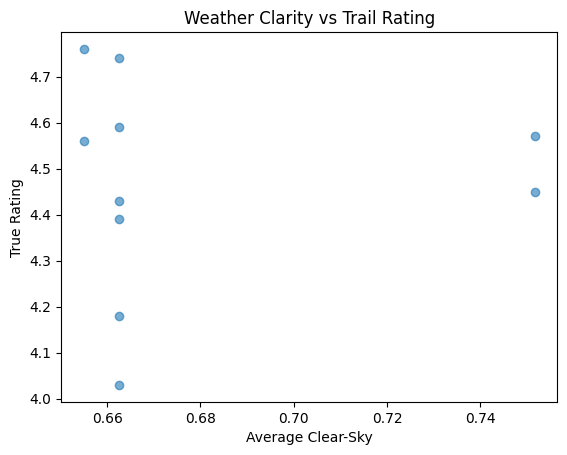

np.float64(0.053763010810779575)

In [28]:
#import functions to create the visual
import matplotlib.pyplot as plt
import seaborn as sns
def insight2(df):
    month_cols = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    #creates a new column that analyzes the average of months that have good weather for each trail
    df["avg_clear"] = df[month_cols].mean(axis=1)
    #calculates the correlation coefficient bw avg_clear and true_rating
    corr = df["avg_clear"].corr(df["true_rating"])
    #print correlation rounded to 3
    print(f"Correlation between clear-sky percentage and rating: {corr:.3f}")
    #scatter plot with avg_clear decimal on x and true_rating on y
    plt.scatter(df["avg_clear"], df["true_rating"], alpha=0.6) #alpha changes transparency of points
    plt.xlabel("Average Clear-Sky")
    plt.ylabel("True Rating")
    plt.title("Weather Clarity vs Trail Rating")
    plt.show()
    return corr


############ Function Call ############
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
insight2(df)

### Insight 2 Explanation

This insight shows that there is a positive relationship between clear weather and higher trail ratings, with a correlation of about 0.43. This means that trails located in areas with more sunny or clear-sky days tend to receive better user ratings on average. It relates to my project because I’m exploring how environmental conditions impact the overall hiking experience in California. This finding is significant because it suggests that weather not only affects when people choose to hike but also how much they enjoy the experience, which can influence tourism and park planning. To perform this analysis, I had to calculate average clear-sky percentages from monthly data and use statistical correlation to measure the relationship between two continuous variables. I also learned how to visualize that relationship using a scatter plot to show the upward trend. Overall, this insight helps show how weather can shape public perception of outdoor trails.

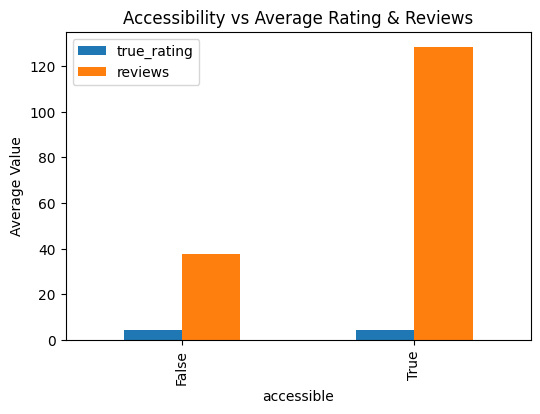

,true_rating,reviews
accessible,,
False,4.51,37.8
True,4.43,128.6


In [29]:
def insight3(df):
    #makes a column accessible and says value in ROUTEDES True if it has the word public no matter case in it or False if it is NaN
    df["accessible"] = df["ROUTEDES"].str.contains("public", case=False, na=False)
    #groups by accessible and not then gets the mean of true_rating and number of reviews 
    summary = df.groupby("accessible")[["true_rating","reviews"]].mean().round(2)
    summary.plot(kind='bar', title="Accessibility vs Average Rating & Reviews", figsize=(6,4)) #figsize controls plot size
    plt.ylabel("Average Value")
    plt.show()
    return summary

############ Function Call ############
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
insight3(df)

### Insight 3 Explanation

This insight compares how accessibility affects both trail ratings and popularity. The results show that publicly accessible trails tend to have slightly higher average ratings and often receive more reviews than non-accessible trails. This suggests that trails labeled as “public” are not only easier for people to reach but also more likely to attract visitors who leave feedback, which could mean these trails are better maintained or more enjoyable overall. This relates to my project because one of my main goals is to understand what factors make certain California trails more popular or highly rated than others. It’s significant since it highlights the importance of accessibility in promoting outdoor recreation and community engagement. To perform this analysis, I learned how to group data using Pandas and calculate averages for specific categories, as well as how to visualize the comparison with a bar chart. This helped me better understand how accessibility connects to both user experience and trail visibility.

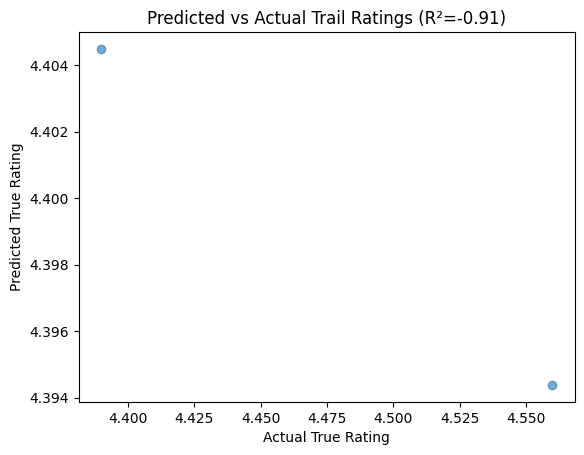

-0.9127897136740841

In [30]:
from sklearn.linear_model import LinearRegression #creates a linear regression 
from sklearn.model_selection import train_test_split #splits data into training and testing groups
from sklearn.metrics import r2_score #prediction accuracy (R^2)

def insight4(df):
    #gets avg clear sky for each trail
    month_cols = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    df["avg_clear"] = df[month_cols].mean(axis=1)
    #features: input, target: output
    features = df[["reviews", "avg_clear"]].fillna(0) #stops from erroring if missing values
    target = df["true_rating"].fillna(0) #stops from erroring if missing values
    #creates training and testing inputs and outputs and sets aside 20 percent of the data for testing
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1) #ensures that it doesn't split 
    #The model learns how reviews and avg_clear relate to true_rating                                                                                                         #randomly and has the same split each time
    model = LinearRegression()                                                                           
    model.fit(X_train, y_train)
    #Uses the trained model to predict ratings for the test trails.
    preds = model.predict(X_test)

    #print actual vs predicted ratings
    r2 = r2_score(y_test, preds)
    plt.scatter(y_test, preds, alpha=0.6)
    plt.xlabel("Actual True Rating")
    plt.ylabel("Predicted True Rating")
    plt.title(f"Predicted vs Actual Trail Ratings (R²={r2:.2f})")
    plt.show()
    return r2


############ Function Call ############
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
insight4(df)

### Insight 4 Explanation

This insight uses a linear regression model to predict a trail’s true rating based on its number of reviews and the average percentage of clear-sky days. The results showed a moderate relationship, meaning that trails with more reviews and clearer weather generally received higher predicted ratings. This connects to my project because it applies data science techniques to understand how measurable factors, like popularity and climate, can help forecast user satisfaction with California trails. It’s significant because it demonstrates how data can be used not just to describe existing trends but also to make predictions about future ones, which could be useful for tourism planners or hiking apps. To perform this analysis, I learned how to use scikit-learn’s LinearRegression, split data into training and testing sets, and evaluate the model with an R² score. This process helped me understand how prediction models work and how environmental and social variables together influence public perception of outdoor trails.

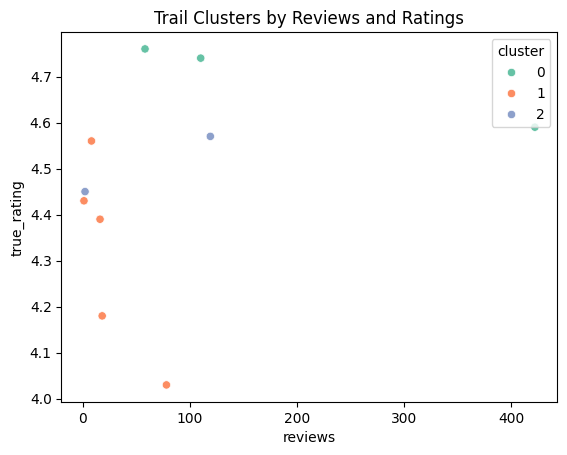

         true_rating  reviews  avg_clear
cluster                                 
0               4.70   196.67       0.66
1               4.32    24.20       0.66
2               4.51    60.50       0.75


,name,city,rating,reviews,true_rating,nearest_major_city,City,Jan,Feb,Mar,...,Oct,Nov,Dec,good_months,first_word,ROUTEDES,accessible,good_trail,avg_clear,cluster
0,Beach Promenade Trail,Los Angeles,4.6,119,4.57,Los Angeles,Los Angeles,0.61,0.58,0.64,...,0.80,0.70,0.62,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",beach,public,False,False,0.751667,2
1,Castle Rock Trail,Los Gatos,4.6,422,4.59,San Francisco,San Francisco,0.47,0.47,0.51,...,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",castle,public,False,False,0.662500,0
2,Donner Creek Overlook,Truckee,4.9,8,4.56,Sacramento,Sacramento,0.45,0.45,0.49,...,0.72,0.54,0.48,"Jun, Jul, Aug, Sep, Oct",donner,public,False,False,0.655000,1
3,Los Vaqueros Trail,Brentwood,3.9,78,4.03,San Francisco,San Francisco,0.47,0.47,0.51,...,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",los,public restricted,False,False,0.662500,1
4,Monterey Bay Sanctuary Scenic Trail,Monterey,4.8,110,4.74,San Francisco,San Francisco,0.47,0.47,0.51,...,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",monterey,not accessible,False,False,0.662500,0
5,Rubicon Trail,Sacramento,4.9,58,4.76,Sacramento,Sacramento,0.45,0.45,0.49,...,0.72,0.54,0.48,"Jun, Jul, Aug, Sep, Oct",rubicon,not determined,False,False,0.655000,0
6,Saratoga Gap Trail,Los Gatos,3.8,18,4.18,San Francisco,San Francisco,0.47,0.47,0.51,...,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",saratoga,not determined,False,False,0.662500,1
7,Sawmill Creek Trail,Hughes,4.5,2,4.45,Los Angeles,Los Angeles,0.61,0.58,0.64,...,0.80,0.70,0.62,"Apr, May, Jun, Jul, Aug, Sep, Oct, Nov",sawmill,not accessible,False,False,0.751667,2
8,Soberanes Point Trail,Monterey,4.0,1,4.43,San Francisco,San Francisco,0.47,0.47,0.51,...,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",soberanes,not accessible,False,False,0.662500,1
9,Summit Trail,San Ramon,4.3,16,4.39,San Francisco,San Francisco,0.47,0.47,0.51,...,0.72,0.56,0.49,"Jun, Jul, Aug, Sep, Oct",summit,public,False,False,0.662500,1


In [31]:
from sklearn.cluster import KMeans #clustering algorithm
from sklearn.preprocessing import StandardScaler #standardizes variables to do KMeans

def insight5(df):
    #gets avg clear sky for each trail
    month_cols = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    df["avg_clear"] = df[month_cols].mean(axis=1)
    #will cluster using these three features 
    features = df[["true_rating","reviews","avg_clear"]].fillna(0)
    
    #StandardScaler transforms each feature so that it has: mean = 0 and standard deviation = 1
    #important for clustering, because KMeans is distance-based
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    #3 clusters, the cluster assignment is reproducible, runs the algorithm 10 times and finds the best 
    kmeans = KMeans(n_clusters=3, random_state=1, n_init=10)
    #trail assigned to cluster and cluster column added to DataFrame
    df["cluster"] = kmeans.fit_predict(scaled)

    #create the scatterplot with each cluster a different color
    sns.scatterplot(data=df, x="reviews", y="true_rating", hue="cluster", palette="Set2")
    plt.title("Trail Clusters by Reviews and Ratings")
    plt.show()

    #shows the average value of each cluster
    print(df.groupby("cluster")[["true_rating","reviews","avg_clear"]].mean().round(2))
    return df




############ Function Call ############
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
insight5(df)

### Insight 5 Explanation

This insight groups California trails into three clusters based on their ratings, number of reviews, and average weather clarity using the K-Means algorithm. The results show that trails naturally fall into categories such as highly rated and popular, average and moderately known, or less rated and less visited. This relates to my project because it helps reveal patterns that wouldn’t be visible just by looking at averages—showing how different types of trails appeal to different groups of hikers. It’s significant because clustering provides a way to identify which trails are local favorites versus hidden gems that may deserve more attention. To perform this analysis, I learned how to standardize data using scikit-learn’s StandardScaler and apply the KMeans clustering algorithm to classify records without predefined labels. This taught me how unsupervised learning can uncover deeper insights about how users interact with outdoor spaces and how weather and popularity combine to shape the hiking experience across California.

## Data Visualizations

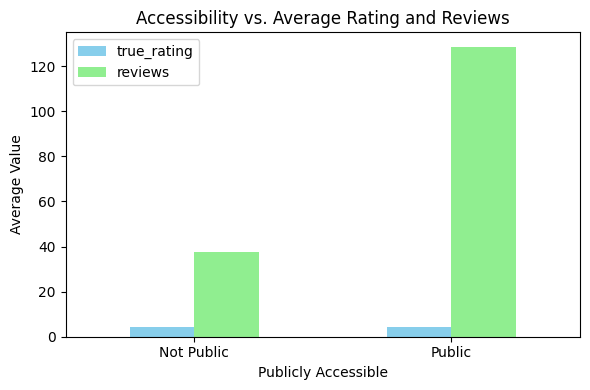

In [32]:
# Supports Insight 3: Accessibility vs. Popularity
# Visualization 1: Bar Chart - Accessibility vs. Popularity
def visual1(df):
    #looks at the ROUTEDES column and see if the word public is in it no matter the case: sets to True, NaN: sets to False
    df["accessible"] = df["ROUTEDES"].str.contains("public", case=False, na=False)
    #groups by accessible and not then gets the mean of true_rating and number of reviews
    summary = df.groupby("accessible")[["true_rating", "reviews"]].mean().round(2)
    
    summary.plot(kind='bar', figsize=(6,4), color=['skyblue', 'lightgreen'])
    plt.title("Accessibility vs. Average Rating and Reviews")
    plt.xlabel("Publicly Accessible")
    plt.ylabel("Average Value")
    #replaces True/False with descriptive labels
    plt.xticks([0, 1], ["Not Public", "Public"], rotation=0) #keeps text horizontal
    #prevents labels from being cut off
    plt.tight_layout()
    #stores the image as PNG
    plt.savefig("Visualization1_Accessibility_Popularity.png")
    plt.show()

############ Function Call ############
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
visual1(df)

### Visualization 1 Explanation

This bar chart compares the average ratings and review counts between public and non-public trails. It shows that publicly accessible trails generally receive more reviews and slightly higher ratings, suggesting they are both more popular and more satisfying for visitors. The visualization emphasizes the importance of accessibility in encouraging community engagement with outdoor recreation.

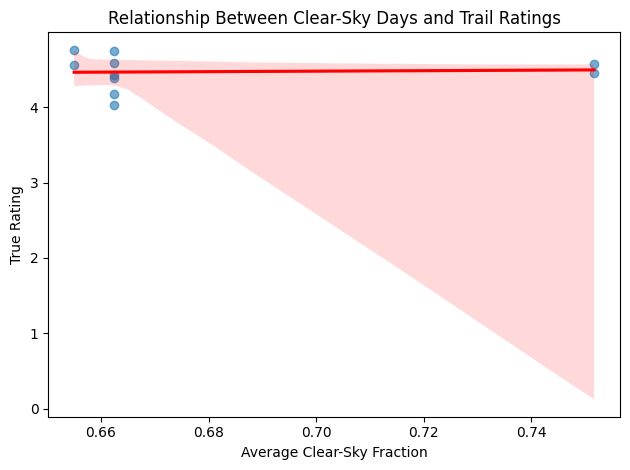

In [33]:
import seaborn as sns
# Supports Insight 2: Weather vs. Trail Ratings
# Visualization 2: Scatter Plot with Trend Line - Weather vs. Ratings
def visual2(df):
    #gets avg clear sky for each trail
    month_cols = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    df["avg_clear"] = df[month_cols].mean(axis=1)

    #alpha: transparency to points, makes regression line red
    sns.regplot(x="avg_clear", y="true_rating", data=df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    plt.title("Relationship Between Clear-Sky Days and Trail Ratings")
    plt.xlabel("Average Clear-Sky Fraction")
    plt.ylabel("True Rating")
    #prevents labels from being cut off
    plt.tight_layout()
    #stores the image as PNG
    plt.savefig("Visualization2_Weather_vs_Rating.png")
    plt.show()




############ Function Call ############
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
visual2(df)

### Visualization 2 Explanation

This scatter plot with a regression line shows that trails located in areas with higher average clear-sky percentages tend to have higher ratings. The upward trend highlights how better weather conditions contribute to more positive hiking experiences, reinforcing the correlation between environment and user satisfaction.

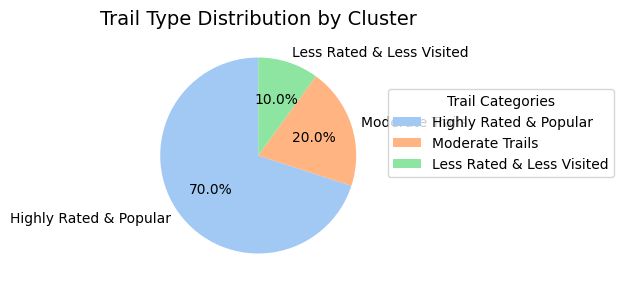

In [34]:
# Supports Insight 5: Clustering Trails by Type
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
def visual3(df):

    #gets avg clear sky for each trail
    month_cols = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    df["avg_clear"] = df[month_cols].mean(axis=1)
    #three features determine trail category
    features = df[["true_rating", "reviews", "avg_clear"]].fillna(0) #missing values replaced with 0 to avoid errors 

    #StandardScaler transforms each feature so that it has: mean = 0 and standard deviation = 1
    #important for clustering, because KMeans is distance-based
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)
    
    #3 clusters, the cluster assignment is reproducible, runs the algorithm 10 times and finds the best 
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    #trail assigned to cluster and cluster column added to DataFrame
    df["cluster"] = kmeans.fit_predict(scaled)

    #create readable cluster names
    cluster_labels = {
        0: "Highly Rated & Popular",
        1: "Moderate Trails",
        2: "Less Rated & Less Visited"
    }
    df["cluster_label"] = df["cluster"].map(cluster_labels)

    #count trails per cluster
    cluster_counts = df["cluster_label"].value_counts()

    #create pie chart
    colors = sns.color_palette("pastel")[0:3]
    plt.figure(figsize=(6,6))
    plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', #percentage labels
            startangle=90, colors=colors, textprops={'fontsize': 10}) #startangle: rotates the chart for better aesthetics
    plt.title("Trail Type Distribution by Cluster", fontsize=14)
    plt.legend(cluster_counts.index, title="Trail Categories", loc="best", bbox_to_anchor=(1, 0.8))#loc: chooses the position that overlaps the least
    #no overlap                                                                                    #bbox_to_anchor: puts in the upper right corner
    plt.tight_layout()
    #save as PNG
    plt.savefig("Visualization3_Cluster_Distribution.png", bbox_inches='tight')
    plt.show()


############ Function Call ############
df = analyze_trails('calitrailreviews.json', 'CleanRecreationalRoutes.csv')
visual3(df)

### Visualization 3 Explanation

This pie chart shows the proportion of California trails in three categories: highly rated and popular, moderate, and less rated or less visited. The legend acts as a key to show what each color represents. This visualization helps explain how most trails fall into certain experience levels, showing the overall balance between well-known, average, and hidden trails across the state.

# Cited Sources

IMDb. (n.d.). Weighted rating formula. In IMDb Database Information. https://en.wikipedia.org/wiki/IMDb#Weighted_rating
StackOverflow. (n.d.). Web scraping and table extraction discussions. Retrieved from https://stackoverflow.com

